# Setup

Importing the modules

In [1]:
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Colormap, Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable

from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
import cartopy.crs as ccrs
import cartopy

import pandas as pd
import random
import numpy as np

from tqdm.auto import tqdm
import os
import sys

import openpyxl


Reading data sources

In [2]:
# data = pd.read_csv('../Documents/14_07_22_VW_AAAQ_mastersheet - Mastersheet.csv')
excel_file = '../Documents/14_07_22_VW_AAAQ_mastersheet__26_NOV_23.xlsx'
reader = Reader('../Documents/maps-master/States/Admin2.shp')
results = '../Results/raw-value-based/'

wb = openpyxl.load_workbook(excel_file)
ws = wb['Mastersheet_raw_values_based_de']

hidden_cols = []
for i, (_, dimension) in enumerate(ws.column_dimensions.items()):
    if dimension.hidden is True:
        hidden_cols.extend(list(range(dimension.min - 1, dimension.max)))
        
data = pd.read_excel(excel_file)

unhidden = np.setdiff1d(np.arange(data.shape[1]), hidden_cols)

data = data.iloc[:, unhidden].replace('#DIV/0!', np.nan)

change_cols =['ApD_sex_mix_1981_1991_percent_decadal_change',
              'ApD_sex_mix_1991_2001_percent_decadal_change',
              'ApD_sex_mix_2001_2011_percent_decadal_change',
              'QD_1981_1991_percent_decadal_change',
              'QD_1991_2001_percent_decadal_change',
              'QD_2001_2011_percent_decadal_change']
data = data.drop(change_cols, axis=1, errors='ignore')


Cleaning required data sets

In [3]:
state_geoms = {record.attributes['ST_NM'].lower(): record.geometry
               for record in reader.records()}
state_geoms['n.c.t. of delhi'] = state_geoms.pop('delhi')
state_geoms['andaman & nicobar islands'] = state_geoms.pop('andaman & nicobar')
state_geoms['dadra & nagar haveli'] = state_geoms.pop('dadra and nagar haveli and daman and diu')
state_geoms['jammu & kashmir'] = (
    state_geoms['jammu & kashmir'].union(state_geoms.pop('ladakh')))
state_geoms['andhra pradesh'] = (
    state_geoms['andhra pradesh'].union(state_geoms.pop('telangana')))

states = data.iloc[:, 0].str.lower().str.strip()
cadres = data.iloc[:, 1].str.lower()
values = data.filter(regex=(
    r'^((A(v|s|p)D)|QD)_((?P<thresh>[a-zA-Z0-9_]+)_)?[0-9]{4}'))
replace_dict = {'#DIV/0!': np.nan, 'ERROR': np.nan, '#VALUE!': np.nan}
values = values.replace(replace_dict).astype(float)
cleaned = values.set_index([states, cadres])

extracted = cleaned.columns.str.extract(
    r'^(?P<variable>.*)_(?P<year>[0-9]{4})(_using_(?P<method>[a-zA-Z_]+))?$')

extracted_year_isna = extracted['year'].isna()
extracted = extracted[~extracted_year_isna]
cleaned = cleaned.loc[:, ~extracted_year_isna.to_numpy()]

extracted['year'] = extracted['year'].astype(int)
extracted = extracted.drop(2, axis=1)
extracted['method'] = extracted['method'].fillna('default')
extracted['variable'] = extracted['variable'].replace({
    'AvD_IHME_UHC_90': 'AvD_IHME_UHC90'
})

cleaned.columns =  pd.MultiIndex.from_tuples(
    extracted.to_numpy().tolist(), names=extracted.columns)
cleaned = cleaned.stack([0, 1]).swaplevel('cadres', 'year').sort_index()
# digitized = cleaned.where(np.isnan(cleaned),
#                           np.digitize(cleaned, np.arange(-0.75, 1, 0.25))
#                           )
# 

# Temporarily dropping Goa due to conflicts
cleaned = cleaned.drop(['goa', 'daman & diu'])
cleaned = cleaned['default']
# cleaned_copy = cleaned.copy()

# cleaned = cleaned_copy['default'].where(
#     ~cleaned_copy['default'].isna(), cleaned_copy['recent_decadal_change_rate']
# )


In [4]:
extracted['variable'].replace({'AvD_IHME_UHC_90', 'AvD_IHME_UHC90'})

0                      AvD_HLEG
1                     AvD_Bhore
2                AvD_IHME_UHC80
3                AvD_IHME_UHC90
4                      AvD_IPHS
                 ...           
167         ApD_cadre_mix_Bhore
168    ApD_cadre_mix_IHME_UHC80
169    ApD_cadre_mix_IHME_UHC90
170          ApD_cadre_mix_IPHS
171                          QD
Name: variable, Length: 171, dtype: object

# Outline

Dimension:

1. Variable
2. Year
3. State
4. Cadres

Required plots:

1. Deficit plots: Year on x-axis, deficit on y-axis (for all cadres), plot for each state and variable
2. Maps: States colored by deficit (binned), plot for each variable, year, and cadre


## Defining plot labels

In [5]:
cadre_label_mapping = {
    'nurse': 'Nurse',
    'nursing cadres': 'Nurse',
    'dentist': 'Dentist',
    'pharmacist': 'Pharmacist',
    'anm': 'ANM',
    'ayush': 'AYUSH',
    'doctor': 'Doctor',
    'skilled health professionals': 'Skilled Health Professionals',
    'nursing cadres': 'Nursing Cadres',
    'supporting cadres': 'Supporting Cadres'
}
varname_mapping = {
    'ApD_cadre_mix_Bhore': 'Acceptability Deficit (ApD) cadre-mix as per Bhore norms',
    'ApD_cadre_mix_HLEG': 'Acceptability Deficit (ApD) cadre-mix as per as per HLEG norms',
    'ApD_cadre_mix_IHME_UHC80': 'Acceptability Deficit (ApD) cadre-mix as per IHME UHC80 norms',
    'ApD_cadre_mix_IHME_UHC90': 'Acceptability Deficit (ApD) cadre-mix as per IHME UHC90 norms',
    'ApD_cadre_mix_IPHS': 'Acceptability Deficit (ApD) cadre-mix as per IPHS norms',
    'ApD_sex_mix': 'Acceptability Deficit (ApD) sex-mix',

    'AsD': 'Accessibility Deficit (AsD)',
    
    'AvD_Bhore': 'Availability Deficit (AvD) as per Bhore norms',
    'AvD_HLEG': 'Availability Deficit (AvD) as per HLEG norms',
    'AvD_IHME_UHC80': 'Availability Deficit (AvD) as per IHME UHC80 norms',
    'AvD_IHME_UHC90': 'Availability Deficit (AvD) as per IHME UHC90 norms',
    'AvD_IPHS': 'Availability Deficit (AvD) as per IPHS norms',
    'AvD_MDG': 'Availability Deficit (AvD) as per MDG norms',
    'AvD_SDG': 'Availability Deficit (AvD) as per SDG norms',
    
    'QD': 'Quality deficit (QD)',
    
    'AvD_male_Bhore': 'Availability Deficit (AvD) for male population\nas per Bhore norms',
    'AvD_male_HLEG': 'Availability Deficit (AvD) for male population\nas per HLEG norms',
    'AvD_male_HME_UHC80': 'Availability Deficit (AvD) for male population\nas per HME_UHC80 norms',
    'AvD_male_IHME_UHC80': 'Availability Deficit (AvD) for male population\nas per IHME_UHC80 norms',
    'AvD_male_IHME_UHC90': 'Availability Deficit (AvD) for male population\nas per IHME_UHC90 norms',
    'AvD_male_IPHS': 'Availability Deficit (AvD) for male population\nas per IPHS norms',
    'AvD_male_MDG': 'Availability Deficit (AvD) for male population\nas per MDG norms',
    'AvD_male_SDG': 'Availability Deficit (AvD) for male population\nas per SDG norms',
    'AvD_male_UHC_80': 'Availability Deficit (AvD) for male population\nas per UHC 80 norms',
    'AvD_male_UHC_90': 'Availability Deficit (AvD) for male population\nas per UHC 90 norms',
    'AvD_urban_Bhore': 'Availability Deficit (AvD) for urban population\nas per Bhore norms',
    'AvD_urban_HLEG': 'Availability Deficit (AvD) for urban population\nas per HLEG norms',
    'AvD_urban_HME_UHC80': 'Availability Deficit (AvD) for urban population\nas per HME UHC80 norms',
    'AvD_urban_IHME_UHC80': 'Availability Deficit (AvD) for urban population\nas per IHME UHC80 norms',
    'AvD_urban_IHME_UHC90': 'Availability Deficit (AvD) for urban population\nas per IHME UHC90 norms',
    'AvD_urban_IPHS': 'Availability Deficit (AvD) for urban population\nas per IPHS norms',
    'AvD_urban_MDG': 'Availability Deficit (AvD) for urban population\nas per MDG norms',
    'AvD_urban_SDG': 'Availability Deficit (AvD) for urban population\nas per SDG norms',
    'AvD_urban_UHC_80': 'Availability Deficit (AvD) for urban population\nas per UHC80 norms',
    'AvD_urban_UHC_90': 'Availability Deficit (AvD) for urban population\nas per UHC90 norms',
}
cadres_of_interest = (
    'nurse', 'dentist', 'pharmacist', 'anm', 'ayush', 'doctor',
    'skilled health professionals'
)


## Looking at newly added variables

In [6]:
new_vars = set(cleaned.index.get_level_values('variable'))
old_vars = set(varname_mapping.keys())
new_vars - old_vars

set()

In [7]:
cleaned.index.get_level_values('cadres').unique()

Index(['all cadres', 'anm', 'dentist', 'doctor', 'nurse', 'nursing cadres',
       'pharmacist', 'skilled health professionals', 'supporting cadres',
       'ayush'],
      dtype='object', name='cadres')

In [8]:
cleaned.sample(5)

states            year  variable        cadres                      
madhya pradesh    2021  AvD_male_Bhore  pharmacist                      0.975885
mizoram           2001  AvD_urban_IPHS  skilled health professionals   -0.180124
kerala            2001  AvD_SDG         skilled health professionals    0.480218
himachal pradesh  1991  AvD_HLEG        pharmacist                     -1.540725
meghalaya         2011  AsD             doctor                          0.924643
Name: default, dtype: float64

In [9]:
cleaned.index.get_level_values('states').unique()

Index(['andaman & nicobar islands', 'andhra pradesh', 'arunachal pradesh',
       'assam', 'bihar', 'chandigarh', 'chhattisgarh', 'dadra & nagar haveli',
       'gujarat', 'haryana', 'himachal pradesh', 'india', 'jammu & kashmir',
       'jharkhand', 'karnataka', 'kerala', 'lakshadweep', 'madhya pradesh',
       'maharashtra', 'manipur', 'meghalaya', 'mizoram', 'n.c.t. of delhi',
       'nagaland', 'odisha', 'puducherry', 'punjab', 'rajasthan', 'sikkim',
       'tamil nadu', 'tripura', 'uttar pradesh', 'uttarakhand', 'west bengal'],
      dtype='object', name='states')

In [10]:
cleaned.sample(5)

states          year  variable         cadres           
haryana         2031  AvD_male_Bhore   nursing cadres       0.962309
andhra pradesh  1981  AvD_male_HLEG    anm                  0.954365
chhattisgarh    2021  AvD_Bhore        anm                  0.604689
india           2021  AvD_male_UHC_80  supporting cadres    0.944540
kerala          1991  ApD_sex_mix      doctor               0.620617
Name: default, dtype: float64

In [11]:
cleaned.loc[:, :, 'ApD_sex_mix', :].groupby(level='cadres').count()

cadres
all cadres                      168
anm                               1
ayush                           166
dentist                         168
doctor                          168
nurse                           168
nursing cadres                  168
pharmacist                      168
skilled health professionals    168
supporting cadres               168
Name: default, dtype: int64

# Line plots

In [49]:
gb = cleaned.groupby(['states', 'variable'])

cadre_colors = {
    cadre: f'C{i}' for i, cadre in 
    enumerate(cadres_of_interest + ('nursing cadres', 'supporting cadres'))
}

proj_year = 2011

line_results = os.path.join(results, 'lines')
if not os.path.exists(line_results):
    os.mkdir(line_results)

for (state, varname), group in tqdm(list(gb)):
    if varname not in varname_mapping:
        print(f'skipping {varname}, not present in the mapping', 
              file=sys.stderr)
        continue
        
    if varname.startswith('ApD_cadre_mix'):
        cadre_intersection = (
            set(group.index.get_level_values('cadres')) &
            set(['nursing cadres', 'supporting cadres'])
        )
    else:
        cadre_intersection = (
            set(group.index.get_level_values('cadres')) &
            set(cadres_of_interest)
        )
        
    if varname == 'ApD_sex_mix' and 'anm' in cadre_intersection:
        cadre_intersection.remove('anm')
    
    if len(cadre_intersection) == 0:
        continue
        
    frame = group.loc[pd.IndexSlice[:, :, :, cadre_intersection]]
    
    varname_results = os.path.join(line_results, varname)
    if not os.path.exists(varname_results):
        os.mkdir(varname_results)

    fig_path = os.path.join(varname_results, f'{state}.pdf')
    
    if os.path.exists(fig_path):
        continue
    print(fig_path)
    
    fig, ax = plt.subplots(figsize=(7, 4), facecolor='white')
    ax.set_position([0.15,0.1,0.5,0.8])
    
    ax.axhline(0, color='gray', lw=0.5)
        
    xticks = sorted(frame.index.get_level_values('year').unique())
    ax.set_xticks(xticks)
    
    ymax, ymin = -np.inf, np.inf
    for cadre, series in frame.groupby('cadres'):
        color = cadre_colors[cadre]

        series = series.droplevel(['states', 'variable', 'cadres'])
        series = np.clip(series, a_min=-1, a_max=1)
        
        ymax, ymin = max(ymax, series.max()), min(ymin, series.min())
        
        real = series[series.index <= proj_year]
        # intentionally overriding proj_year below with >= to make sure
        # that the lines are not discontinuous
        proj = series[series.index >= proj_year]
        
        props = dict(ax=ax, marker='o', ls='--', c=color, ms=10)
        real.plot(label=cadre_label_mapping[cadre], **props)
        proj.plot(label='_nolegend_', 
                  markerfacecolor='none', markeredgewidth=2, **props)

    var_full_name = varname_mapping[varname]
    ax.set_ylabel(var_full_name)
    
    if state != 'india':
        title = f'{state.title()}'
        ax.set_title(title, size='x-large')
        
    ax.set_xlabel('Year')
    ymax, ymin = min(ymax + 0.125, 1.25), max(ymin - 0.125, -1.25)
    ax.set_ylim((ymin, ymax))
    ax.legend(loc='center left', bbox_to_anchor=[1, 0.5])
#     fig.tight_layout()
    
    plt.savefig(fig_path, dpi=450)
    plt.close()


  0%|          | 0/1188 [00:00<?, ?it/s]

../Results/raw-value-based/lines/AvD_urban_SDG/chhattisgarh.pdf


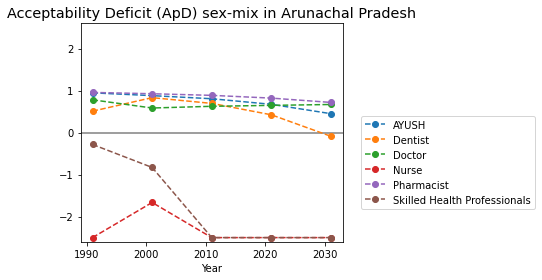

In [13]:
state, varname = 'arunachal pradesh', 'ApD_sex_mix'
group = gb.get_group((state, varname))
fig_path = os.path.join(varname_results, f'{state}.pdf')

fig, ax = plt.subplots(figsize=(7, 4))
ax.axhline(0, color='gray')
ax.set_ylim(-2.6, 2.6)

any_cadre = False
for cadre, series in group.groupby('cadres'):
    if cadre not in cadres_of_interest:
        continue
    any_cadre = True
    series = series.droplevel(['states', 'variable', 'cadres'])
    series = np.clip(series, a_min=-2.5, a_max=2.5)
    series.plot(ax=ax, marker='o', ls='--', 
                label=cadre_label_mapping[cadre])

if any_cadre:
    varname = varname_mapping[varname]
    title = f'{varname} in {state.title()}'
    ax.set_title(title, size='x-large')
    ax.set_xlabel('Year')
    ax.legend(bbox_to_anchor=[1.05, 0.6])
    fig.tight_layout()



# Maps

Test plot for cartopy maps

In [14]:
state_abbr = {
    'andhra pradesh': 'AP',
    'arunachal pradesh': 'AR',
    'assam': 'AS',
    'bihar': 'BR',
    'chhattisgarh': 'CG',
    'goa': 'GA',
    'gujarat': 'GJ',
    'haryana': 'HR',
    'himachal pradesh': 'HP',
    'jammu & kashmir': 'JK',
    'jharkhand': 'JH',
    'karnataka': 'KA',
    'kerala': 'KL',
    'madhya pradesh': 'MP',
    'maharashtra': 'MH',
    'manipur': 'MN',
    'meghalaya': 'ML',
    'mizoram': 'MZ',
    'nagaland': 'NL',
    'odisha': 'OR',
    'punjab': 'PB',
    'rajasthan': 'RJ',
    'sikkim': 'SK',
    'tamil nadu': 'TN',
    'tripura': 'TR',
    'uttarakhand': 'UK',
    'uttar pradesh': 'UP',
    'west bengal': 'WB',
    'andaman & nicobar islands': 'AN',
    'chandigarh': 'CH',
    'dadra & nagar haveli': 'DH',
    'daman and diu': 'DD',
    'n.c.t. of delhi': 'DL',
    'lakshadweep': 'LD',
    'puducherry': 'PY'
}


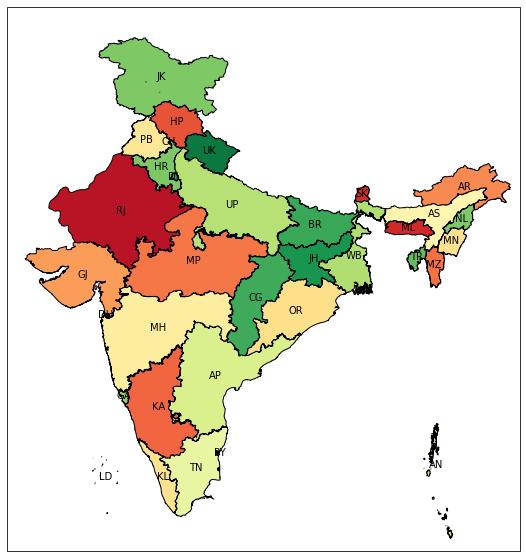

In [15]:
proj = ccrs.PlateCarree()
norm = Normalize(vmin=-1, vmax=1)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.RdYlGn)

fig = plt.figure()
ax = fig.add_subplot(projection=proj)
ax.set_extent([67, 98, 6, 38])

for name, record in state_geoms.items():
    color = 2 * (random.random() - 0.5)
    feature = ShapelyFeature([record], ccrs.PlateCarree(),
                             edgecolor='black', facecolor=mapper.to_rgba(color),
                             lw=1)
    c = record.centroid
    abbr = state_abbr[name]
    ax.add_feature(feature, rasterized=True)
    ax.text(c.x, c.y, abbr, va='center', ha='center')

plt.gcf().set_size_inches(20, 10)
plt.savefig('/tmp/figure.pdf')


In [16]:
map_results = os.path.join(results, 'maps')
if not os.path.exists(map_results):
    os.mkdir(map_results)


## Trial run of the map without save

In [17]:
import random

gb = cleaned.groupby(level=['variable', 'year', 'cadres'])
proj = ccrs.PlateCarree()
for (varname, year, cadre), group in gb:
    if random.random() > 0.9:
        break

In [18]:
if varname == 'QD':
    a_min, a_max, a_step, base = 0.125, 0.875, 0.125, 0
else:
    a_min, a_max, a_step, base = -0.75, 0.75, 0.25, -4
bins = np.arange(a_min, a_max + a_step, a_step)
group = group.where(np.isnan(group), np.digitize(group, bins))


In [19]:
vmin, vmax = 0, 7

In [20]:
norm = Normalize(vmin=vmin - 0.5, vmax=vmax + 0.5)
mapper = cm.ScalarMappable(
    norm=norm, cmap=cm.get_cmap('RdYlGn_r', vmax - vmin + 1))
cticks = np.arange(vmin - 0.5, vmax + 1.5, 1)
cticklabels = np.arange(
    a_step * (vmin + base),
    a_step * (vmax + base) + 2 * a_step,
    a_step
)


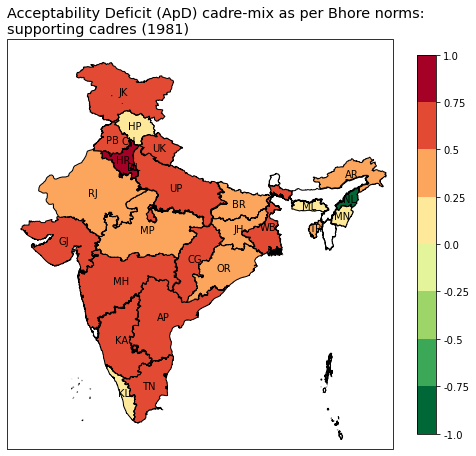

In [21]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(projection=proj)
ax.set_extent([67, 98, 6, 38])

filled = {val: False for val in state_geoms.keys()}
series = group.droplevel(['year', 'variable', 'cadres'])
for state, value in series.items():
    if state == 'india':
        continue
    record = state_geoms[state]
    feature = ShapelyFeature([record], ccrs.PlateCarree(),
                             edgecolor='black', lw=1,
                             facecolor=mapper.to_rgba(value))
    c, abbr = record.centroid, state_abbr[state]
    ax.add_feature(feature)
    ax.text(c.x, c.y, abbr, va='center', ha='center')
    filled[state] = True

for state, is_filled in filled.items():
    if not is_filled:
        record = state_geoms[state]
        feature = ShapelyFeature([record], ccrs.PlateCarree(),
                                 edgecolor='black', facecolor='none',
                                 lw=1)
        ax.add_feature(feature)

cbar = plt.colorbar(mapper, shrink=0.8)
cbar.set_ticks(cticks)
cbar.set_ticklabels(cticklabels)

var_full_name = varname_mapping[varname]

p1 = f'{var_full_name}:'
p2 = f'{cadre} ({year})'
thresh_len = 60
if len(p1 + ' ' + p2) <= thresh_len:
    title = p1 + ' ' + p2
else:
    title = p1 + '\n' + p2

ax.set_title(title, size='x-large', loc='left')
fig.tight_layout()


## Final run of the map

In [43]:
gb = cleaned.groupby(level=['variable', 'year', 'cadres'])

# digitized = cleaned.where(np.isnan(cleaned), np.digitize(cleaned, bins))
proj = ccrs.PlateCarree()

for (varname, year, cadre), group in tqdm(list(gb)):
    if varname not in varname_mapping:
        print(f'skipping {varname}, not found in mapping', file=sys.stderr)
        continue
    
    if varname == 'QD':
        a_min, a_max, a_step, base = 0.125, 0.875, 0.125, 0
    else:
        a_min, a_max, a_step, base = -0.75, 0.75, 0.25, -4
    
    bins = np.arange(a_min, a_max + a_step, a_step)
    group = group.where(np.isnan(group), np.digitize(group, bins))
    
    # commenting the old code to adapt the scale
    # vmin, vmax = group.min(), group.max()
    # 
    # new values for a consistent scale
    vmin, vmax = 0, 7
    
    norm = Normalize(vmin=vmin - 0.5, vmax=vmax + 0.5)
    mapper = cm.ScalarMappable(
        norm=norm, cmap=cm.get_cmap('RdYlGn_r', vmax - vmin + 1))
    cticks = np.arange(vmin - 0.5, vmax + 1.5, 1)
    cticklabels = np.arange(
        a_step * (vmin + base),
        a_step * (vmax + base) + 2 * a_step,
        a_step
    )
    
    varname_results = os.path.join(map_results, varname)
    if not os.path.exists(varname_results):
        os.mkdir(varname_results)
        
    year_results = os.path.join(varname_results, str(year))
    if not os.path.exists(year_results):
        os.mkdir(year_results)
        
    if cadre in cadre_label_mapping:
        cadre = cadre_label_mapping[cadre]
    else:
        cadre = ' '.join([word.capitalize() for word in cadre.split()])
    fig_path = os.path.join(year_results, f'{cadre}.pdf')
    
    if os.path.exists(fig_path):
        continue

    fig = plt.figure(figsize=(7, 7), facecolor='white')
    ax = fig.add_subplot(projection=proj)
    ax.set_extent([67, 98, 6, 38])

    filled = {val: False for val in state_geoms.keys()}
    series = group.droplevel(['year', 'variable', 'cadres'])
    for state, value in series.items():
        if state == 'india':
            continue
        record = state_geoms[state]
        feature = ShapelyFeature([record], ccrs.PlateCarree(),
                                 edgecolor='black', lw=0.5,
                                 facecolor=mapper.to_rgba(value))
        c, abbr = record.centroid, state_abbr[state]
        ax.add_feature(feature, rasterized=True)
        ax.text(c.x, c.y, abbr, va='center', ha='center')
        filled[state] = True

    for state, is_filled in filled.items():
        if not is_filled:
            record = state_geoms[state]
            feature = ShapelyFeature([record], ccrs.PlateCarree(),
                                     edgecolor='black', facecolor='none',
                                     lw=0.5)
            ax.add_feature(feature, rasterized=True)

    cbar = plt.colorbar(mapper, shrink=0.8)
    cbar.set_ticks(cticks)
    cbar.set_ticklabels(cticklabels)
    
    var_full_name = varname_mapping[varname]
    
    p1 = f'{var_full_name}:'
    p2 = f'{cadre} ({year})'
    thresh_len = 60
    if len(p1 + ' ' + p2) <= thresh_len:
        title = p1 + ' ' + p2
    else:
        title = p1 + '\n' + p2
        
    ax.set_title(title, size='x-large', loc='left')
    fig.tight_layout()
    
    plt.savefig(fig_path, dpi=450)
    plt.close()


  0%|          | 0/1034 [00:00<?, ?it/s]

# Repeating with Averages

In [44]:
results = '../Results/raw-value-based/'
line_results = os.path.join(results, 'lines')
map_results = os.path.join(results, 'maps')

In [45]:
import fitz

In [50]:

def create_index_pdf(directory, pdf_files):
    """Create an index PDF for the given directory."""
    doc = fitz.open()  # Create a new PDF to serve as the index
    page = doc.new_page()  # Create a new page for the index
    
    text = f"Index for {directory}\n\n" + "\n".join(pdf_files)
    page.insert_text((72, 72), text)  # Add text to the page
    
    index_pdf_path = os.path.join(directory, "index.pdf")
    doc.save(index_pdf_path)
    doc.close()
    return index_pdf_path

def combine_pdfs(pdf_paths, output_path):
    """Combine multiple PDFs into a single PDF."""
    output_doc = fitz.open()
    for pdf_path in pdf_paths:
        input_doc = fitz.open(pdf_path)
        try:
            output_doc.insert_pdf(input_doc)
        except RuntimeError:
            print(pdf_path)
        input_doc.close()
    output_doc.save(output_path)
    output_doc.close()

def process_directory(root_dir):
    output_pdf_path = "combined_output.pdf"
    all_pdfs_to_combine = []
    
    for root, dirs, files in os.walk(root_dir):
        if not dirs:  # This means it's a leaf directory
            pdf_files = [file for file in files if file.endswith('.pdf')]
            pdf_paths = [os.path.join(root, file) for file in pdf_files]
                        
            # Add the PDF files from the directory
            all_pdfs_to_combine.extend(pdf_paths)
    
    # Combine all PDFs into a single file
    combine_pdfs(all_pdfs_to_combine, output_pdf_path)
    print(f"Combined PDF saved to {output_pdf_path}")

# Replace 'root_directory_path' with the path to your root directory
process_directory(line_results)


Combined PDF saved to combined_output.pdf
